In [78]:
import numpy as np
import pandas as pd
from scipy.fft import fft
import matplotlib.pyplot as plt

## 1
### (a)

In [3]:
def S_ARMA(f, sigma2, phis=[], thetas=[]):
    '''
    Computes the theoretical sdf for an ARMA(p, q) process.

    param f: a numpy array of frequencies at which sdf should be evaluated
    param sigma2: a scalar; the variance of the white noise process
    param phis: a numpy array containing the phi parameters
    param thetas: a numpy array containing the theta parameters
    
    return: a numpy array of sdf evaluated at f
    '''
    p, q = len(phis), len(thetas)
    xis_t = np.exp(-1j*2*np.pi*np.outer(f, np.arange(1, q+1)))
    xis_p = np.exp(-1j*2*np.pi*np.outer(f, np.arange(1, p+1)))
    G_t = 1 - (thetas * xis_t).sum(1)
    G_p = 1 - (phis * xis_p).sum(1)
    return (sigma2 * np.abs(G_t)**2 / np.abs(G_p)**2)

In [4]:
f = np.random.uniform(-0.5, 0.5)
sigma2 = np.random.randn()
phis = [np.random.randn()]

print(S_ARMA(f, sigma2, phis=phis))
print(sigma2 / (1 + phis[0]**2 - 2*phis[0]*np.cos(2*np.pi*f)))

[-1.002464]
-1.0024640024894633


### (b)

In [82]:
def ARMA22_sim(phis, thetas, sigma2, N):
    """
    Simulates a Gaussian ARMA(2,2) process. 

    param phis: a numpy array containing the phi parameters
    param thetas: a numpy array containing the theta parameters
    param sigma2: a scalar; the variance of the white noise process
    N: a scalar; length of the simulated process

    return: a numpy array of size N
    """
    eps = np.random.normal(size=100+N, scale=np.sqrt(sigma2))
    X = np.zeros(100 + N)
    for i in range(2, 100+N):
        X[i] = phis[0]*X[i-1] + phis[1]*X[i-2] + eps[i] \
            - (thetas[0]*eps[i-1] + thetas[1]*eps[i-2])
    return X[-N:]

### (c)

In [6]:
def periodogram(X):
    """
    Computes the periodogram at the Fourier frequencies \
    for a time series X.
    """
    N = X.shape[-1]
    S = fft(X)
    return np.abs(S)**2 / N

In [7]:
def direct(X, p):
    """
    Computes the direct spectral estimate at the Fourier \
    frequencies using the p × 100% cosine taper for a \
    time series X.
    """
    N = X.shape[-1]
    H = np.ones(N,)
    tt = np.floor(p*N)
    H[:int(tt//2)] = (1 - np.cos(2*np.pi*np.arange(tt/2) / (tt+1))) / 2
    H[int(N-tt//2):] = (1 - np.cos(2*np.pi*(N+1-np.arange(tt/2)) / (tt+1))) / 2
    H *= (1 / (H**2).sum())
    hX = H * X
    return np.abs(fft(hX)) ** 2 / N

### (d)
#### (A)

In [83]:
r = 0.8
N = 128
fp = 12/128
phis = np.array([2*r*np.cos(2*np.pi*fp), -r**2])
thetas = np.array([-0.5, -0.2])

X = np.array([ARMA22_sim(phis, thetas, 1, N) for _ in range(10000)])
fs = np.array([12/128, 32/128, 60/128])

per = periodogram(X).T[[12, 32, 60]]    # periodograms

ps = [0.05, 0.1, 0.25, 0.5]
sde_p1 = direct(X, 0.05).T[[12, 32, 60]]
sde_p2 = direct(X, 0.1).T[[12, 32, 60]]
sde_p3 = direct(X, 0.25).T[[12, 32, 60]]
sde_p4 = direct(X, 0.5).T[[12, 32, 60]]

#### (B)

In [84]:
estimates = np.dstack([per, sde_p1, sde_p2, sde_p3, sde_p4])
true_sdf = S_ARMA(fs, sigma2=1, phis=phis, thetas=thetas)
sample_bias_vals = estimates.mean(1).T - true_sdf

# Table
sample_bias = pd.DataFrame(sample_bias_vals, columns=fs)
sample_bias.rename_axis(columns='freq', inplace=True)
sample_bias.set_axis(['periodogram'] + ['Cosine taper, p='+str(p)  for p in ps], axis='index', inplace=True)
sample_bias.name = 'Sample bias, r=0.8'
sample_bias

freq,0.09375,0.25000,0.46875
periodogram,-2.285738,0.123409,0.053803
"Cosine taper, p=0.05",-59.372199,-0.468527,-0.055843
"Cosine taper, p=0.1",-59.372100,-0.468515,-0.055839
"Cosine taper, p=0.25",-59.371764,-0.468516,-0.055838
"Cosine taper, p=0.5",-59.370804,-0.468501,-0.055835


In [87]:
N = 128
fp = 12/128
thetas = [-0.5, -0.2]
r = np.arange(0.8, 1.0, 0.01)
phis = np.array([2*r*np.cos(2*np.pi*fp), -r**2]).T   # 20x2 array
XX = np.array([[ARMA22_sim(phi, thetas, 1, N) for _ in range(10000)] for phi in phis])    # shape=(20, 10000, 128)

perXX = periodogram(XX)[..., [12, 32, 60]]    # shape=(20, 10000, 3)
sde_p1 = direct(XX, 0.05)[..., [12, 32, 60]]
sde_p2 = direct(XX, 0.1)[..., [12, 32, 60]]
sde_p3 = direct(XX, 0.25)[..., [12, 32, 60]]
sde_p4 = direct(XX, 0.5)[..., [12, 32, 60]]

In [105]:
true_sdf = np.array([S_ARMA(fs, sigma2=1, phis=phi, thetas=thetas) for phi in phis])
true_sdf.shape #(20, 3)

sample_mean = np.array([est.mean(1) for est in [perXX, sde_p1, sde_p2, sde_p3, sde_p4]])
sample_bias = sample_mean - true_sdf
sample_bias.shape   #(5, 20, 3)

(5, 20, 3)

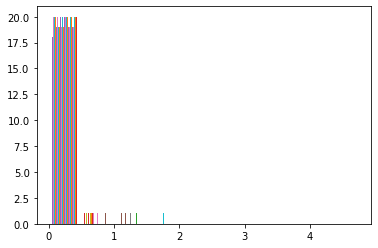

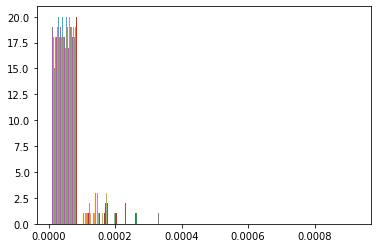

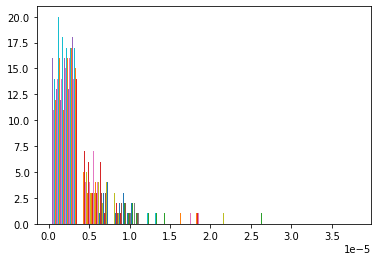

In [115]:
rs = np.arange(0.8, 1.0, 0.01)
for i in range(3):
    plt.figure()
    plt.hist(sde_p1[..., i])

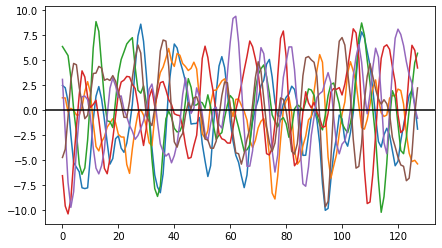

ValueError: x and y can be no greater than 2D, but have shapes (128,) and (128, 10000, 0)

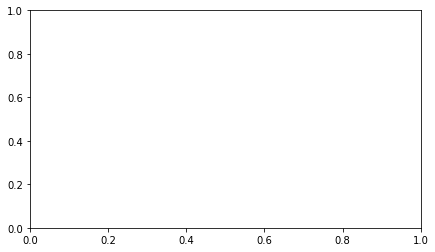

In [110]:
idx = np.random.randint(0, 10000)
plt.figure(figsize=(7, 4))
plt.plot(X[0, idx:idx+6].T)
plt.axhline(y=0, color='k', linestyle='-')
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(np.arange(128), periodogram(X[idx:idx+6]).T)
plt.show()

## 2

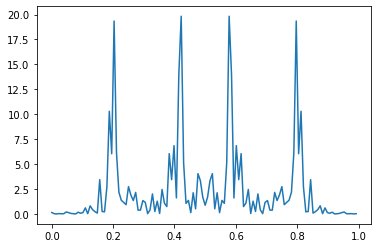

In [48]:
X2 = np.genfromtxt('154.csv', delimiter=',')
per = periodogram(X2)

plt.plot(np.arange(128)/128, per)

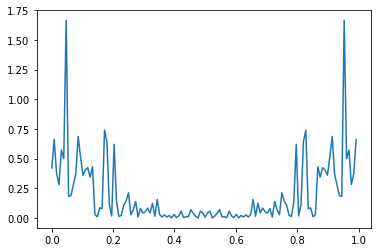

In [54]:
plt.plot(np.arange(128) / 128, np.abs(fft(y)) ** 2 / N)